In [78]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

seed = 2024

## load data

In [79]:
# load into dataframe
data = pd.read_csv("data/cs-training.csv", index_col = 0)
# print(data.describe())
print(data.shape)
data.head()

(150000, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## fill missing value

In [80]:
# check nan values
print(data.isna().sum(axis=0))

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


In [81]:
# fill in nan values with mean
data["MonthlyIncome"] = data["MonthlyIncome"].fillna(data["MonthlyIncome"].mean())
data["NumberOfDependents"] = data["NumberOfDependents"].fillna(data["NumberOfDependents"].mean())
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## preprocess train and test sets

In [82]:
# split train and test set
from sklearn.model_selection import train_test_split

X = data.drop(columns="SeriousDlqin2yrs")
y = data[["SeriousDlqin2yrs"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)


In [ ]:
# standardize values before learning
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
y_train = np.array(y_train["SeriousDlqin2yrs"])
y_test = np.array(y_test["SeriousDlqin2yrs"])

## select features using logistic regression and L1

In [83]:
from sklearn.linear_model import LogisticRegression

#record the number of coef

coef = 10. ** np.arange(-5, 5)
fea = {}

#record the estimation results of coef
param = {}
for c in tqdm(coef):
    lr = LogisticRegression(C=c, penalty = "l1",random_state=seed, solver = "liblinear", multi_class='ovr')
    lr.fit(X_train_std, y_train)
    fea_num = sum(sum(lr.coef_ !=0))
    fea[c] = fea_num
    param[c] = lr.coef_

100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


In [84]:
fea

{1e-05: 0,
 0.0001: 0,
 0.001: 2,
 0.01: 8,
 0.1: 10,
 1.0: 10,
 10.0: 10,
 100.0: 10,
 1000.0: 10,
 10000.0: 10}

In [85]:
# when c=0.001, number of features is 2, which are second and third
print(param[0.001])

[[ 0.         -0.28797808  0.11461071  0.          0.          0.
   0.          0.          0.          0.        ]]


In [86]:
#select 2 features and train LR
X_train_std_2 = X_train_std[:,1:3]
X_test_std_2 = X_test_std[:,1:3]



## use plot_decision_regions function from Chapter 3

In [87]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        
        if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')
        else:
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')

## LR

In [88]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


C = [0.1, 0.5, 1, 5, 10]
param_acc = {}
for i in tqdm(C):
    lr = LogisticRegression(C=1.0, penalty = "l1", solver = "liblinear", multi_class='ovr', random_state=seed)
    lr.fit(X_train_std_2, y_train)
    y_predict = lr.predict(X_test_std_2)
    acc = accuracy_score(y_test, y_predict)
    param_acc[f"C: {i}"] = acc

param_acc

100%|██████████| 5/5 [00:00<00:00, 14.12it/s]


{'C: 0.1': 0.9333333333333333,
 'C: 0.5': 0.9333333333333333,
 'C: 1': 0.9333333333333333,
 'C: 5': 0.9333333333333333,
 'C: 10': 0.9333333333333333}

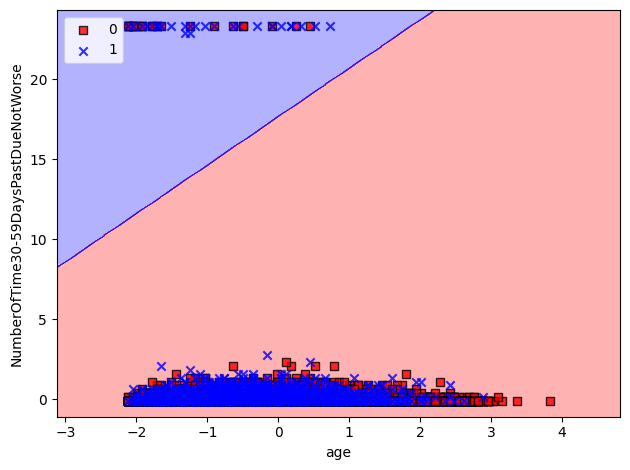

In [89]:
lr = LogisticRegression(C=1.0, penalty = "l1", solver = "liblinear", multi_class='ovr', random_state=seed)
lr.fit(X_train_std_2, y_train)

plot_decision_regions(X_test_std_2, y_test, classifier=lr)
plt.xlabel(data.columns[1+1])
plt.ylabel(data.columns[1+2])
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

## SVM

In [90]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

gamma = [0.1, 0.5, 1, 5, 10]
C = [0.1, 0.5, 1, 5, 10]
param_acc = {}
for i in tqdm(gamma):
    for j in C:
        svm = SVC(kernel='rbf', gamma= i, C= j , max_iter = 1000, random_state=seed)
        svm.fit(X_train_std_2, y_train)
        y_predict = svm.predict(X_test_std_2)
        acc = accuracy_score(y_test, y_predict)
        param_acc[f"gamma: {i}, C: {j}"] = acc

param_acc

100%|██████████| 5/5 [05:41<00:00, 68.28s/it]


{'gamma: 0.1, C: 0.1': 0.18956666666666666,
 'gamma: 0.1, C: 0.5': 0.18956666666666666,
 'gamma: 0.1, C: 1': 0.18956666666666666,
 'gamma: 0.1, C: 5': 0.18956666666666666,
 'gamma: 0.1, C: 10': 0.18956666666666666,
 'gamma: 0.5, C: 0.1': 0.7371333333333333,
 'gamma: 0.5, C: 0.5': 0.7371333333333333,
 'gamma: 0.5, C: 1': 0.7371333333333333,
 'gamma: 0.5, C: 5': 0.7371333333333333,
 'gamma: 0.5, C: 10': 0.7371333333333333,
 'gamma: 1, C: 0.1': 0.4585,
 'gamma: 1, C: 0.5': 0.4585,
 'gamma: 1, C: 1': 0.4585,
 'gamma: 1, C: 5': 0.6462,
 'gamma: 1, C: 10': 0.29843333333333333,
 'gamma: 5, C: 0.1': 0.7040666666666666,
 'gamma: 5, C: 0.5': 0.7336333333333334,
 'gamma: 5, C: 1': 0.7336333333333334,
 'gamma: 5, C: 5': 0.8810333333333333,
 'gamma: 5, C: 10': 0.5480333333333334,
 'gamma: 10, C: 0.1': 0.9154,
 'gamma: 10, C: 0.5': 0.9154666666666667,
 'gamma: 10, C: 1': 0.9154666666666667,
 'gamma: 10, C: 5': 0.7279333333333333,
 'gamma: 10, C: 10': 0.8420666666666666}

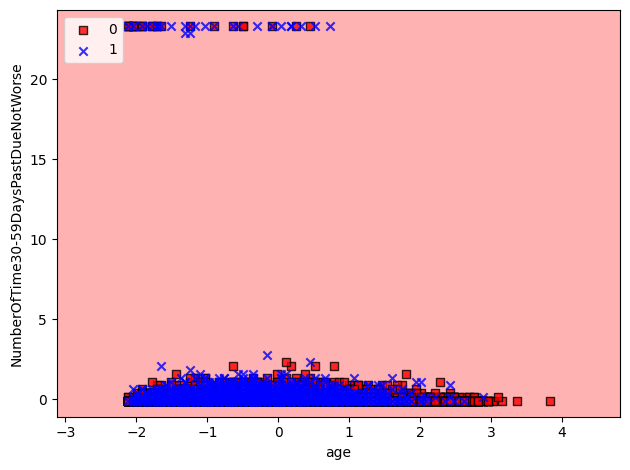

In [91]:
svm = SVC(kernel='rbf', gamma= 10, C= 1 , max_iter = 1000, random_state=seed)
svm.fit(X_train_std_2, y_train)

plot_decision_regions(X_test_std_2, y_test, classifier=svm)
plt.xlabel(data.columns[1+1])
plt.ylabel(data.columns[1+2])
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

## decision tree

In [92]:
from sklearn.tree import DecisionTreeClassifier

depth = list(range(1, 50))

param_acc = {}
for i in tqdm(depth):
    tree = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=seed)
    tree.fit(X_train_std_2, y_train)
    y_predict = tree.predict(X_test_std_2)
    acc = accuracy_score(y_test, y_predict)
    param_acc[f"depth: {i}"] = acc

param_acc

100%|██████████| 49/49 [00:01<00:00, 24.91it/s]


{'depth: 1': 0.9331666666666667,
 'depth: 2': 0.9331666666666667,
 'depth: 3': 0.9331666666666667,
 'depth: 4': 0.9331666666666667,
 'depth: 5': 0.9331333333333334,
 'depth: 6': 0.9335,
 'depth: 7': 0.9335666666666667,
 'depth: 8': 0.9337,
 'depth: 9': 0.9336666666666666,
 'depth: 10': 0.9335,
 'depth: 11': 0.9337333333333333,
 'depth: 12': 0.9335333333333333,
 'depth: 13': 0.9339,
 'depth: 14': 0.9337333333333333,
 'depth: 15': 0.9335333333333333,
 'depth: 16': 0.9335333333333333,
 'depth: 17': 0.9336,
 'depth: 18': 0.9335666666666667,
 'depth: 19': 0.9335666666666667,
 'depth: 20': 0.9335666666666667,
 'depth: 21': 0.9335666666666667,
 'depth: 22': 0.9335666666666667,
 'depth: 23': 0.9335666666666667,
 'depth: 24': 0.9335666666666667,
 'depth: 25': 0.9335666666666667,
 'depth: 26': 0.9335666666666667,
 'depth: 27': 0.9335666666666667,
 'depth: 28': 0.9335666666666667,
 'depth: 29': 0.9335666666666667,
 'depth: 30': 0.9335666666666667,
 'depth: 31': 0.9335666666666667,
 'depth: 32': 0

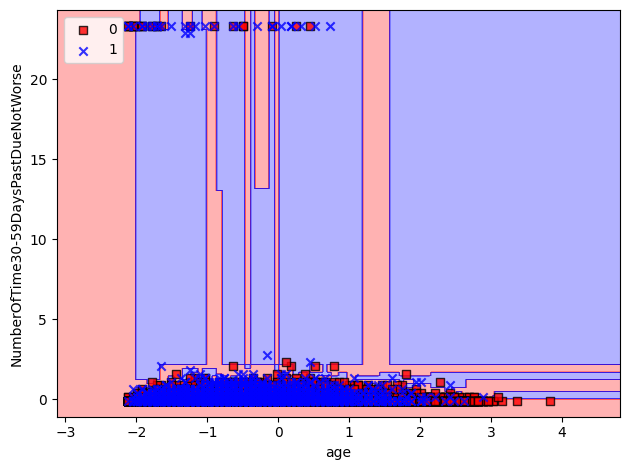

In [93]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=18, random_state=seed)
tree.fit(X_train_std_2, y_train)

plot_decision_regions(X_test_std_2, y_test, classifier=tree)
plt.xlabel(data.columns[1+1])
plt.ylabel(data.columns[1+2])
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

## RF

In [94]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = list(range(10, 101, 10))
param_acc = {}
for i in tqdm(n_estimators):
    forest = RandomForestClassifier(criterion='gini',
                                n_estimators=i, 
                                random_state=seed,
                                n_jobs=-1)
    forest.fit(X_train_std_2, y_train)
    y_predict = forest.predict(X_test_std_2)
    acc = accuracy_score(y_test, y_predict)
    param_acc[f"n_estimators: {i}"] = acc

param_acc

100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


{'n_estimators: 10': 0.9334333333333333,
 'n_estimators: 20': 0.9335333333333333,
 'n_estimators: 30': 0.9335333333333333,
 'n_estimators: 40': 0.9334,
 'n_estimators: 50': 0.9334666666666667,
 'n_estimators: 60': 0.9333666666666667,
 'n_estimators: 70': 0.9334333333333333,
 'n_estimators: 80': 0.9333666666666667,
 'n_estimators: 90': 0.9334,
 'n_estimators: 100': 0.9333}

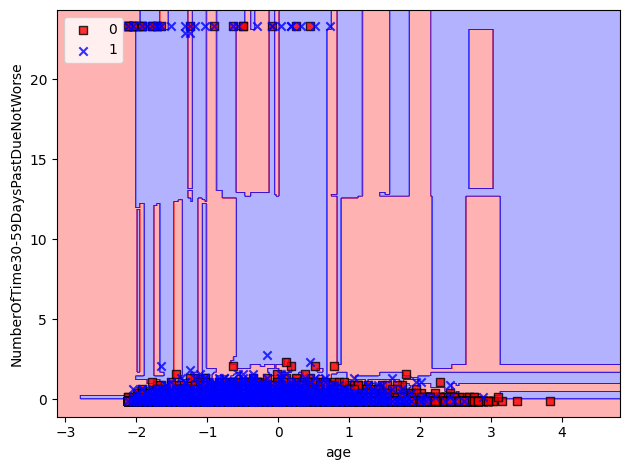

In [95]:
forest = RandomForestClassifier(criterion='gini', n_estimators=40, random_state=seed, n_jobs=-1)
forest.fit(X_train_std_2, y_train)

plot_decision_regions(X_test_std_2, y_test, classifier=forest)
plt.xlabel(data.columns[1+1])
plt.ylabel(data.columns[1+2])
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

In decision region plots, many samples of class 1 are predicted wrongly. 

Samples classified into class overlap a lot.

Maybe 2 features are not enough to train the models, we can add more features to improve.